In [113]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline


Tensorflow: v2.0.0


In [114]:
def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

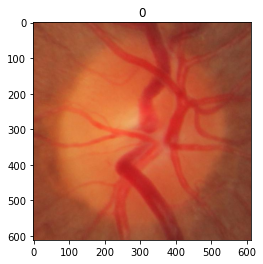

In [115]:
image, label = load('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/training_set/train/normal/r2_Im034.png', 0)

fig, ax = plt.subplots()
ax.imshow(image /255.)
ax.set_title(label)
plt.show()

In [116]:
def resize(input_image, size):
    return tf.image.resize(input_image, size)

In [117]:
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 3])

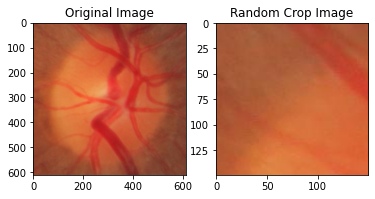

In [118]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Random Crop Image")
plt.show()

In [119]:
def central_crop(input_image):
    image = resize(input_image, [176, 176])
    return tf.image.central_crop(image, central_fraction=0.84)

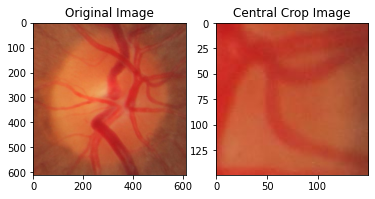

In [120]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Central Crop Image")
plt.show()

In [121]:
def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

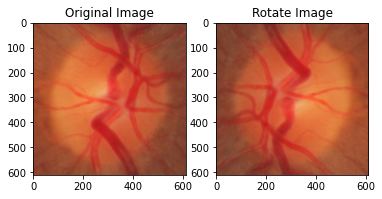

In [122]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_rotation(image) / 255.)
ax[1].set_title("Rotate Image")
plt.show()

In [123]:
def random_jitter(input_image):
    # Resize it to 176 x 176 x 3
    image = resize(input_image, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image

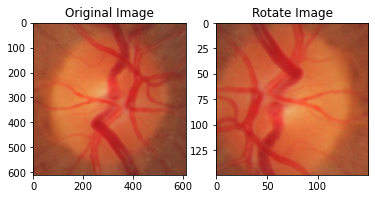

In [124]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_jitter(image) / 255.)
ax[1].set_title("Rotate Image")
plt.show()

In [125]:
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image

In [126]:
def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

In [127]:
temp_ds = tf.data.Dataset.list_files(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/training_set/', 'train', 'normal', '*.png'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/training_set/', 'train', 'glaucoma', '*.png'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

train_ds = temp_ds.concatenate(temp2_ds)

In [128]:
buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size)\
                   .map(load_image_train, num_parallel_calls=16)\
                   .batch(20)\
                   .repeat()

In [129]:
temp_ds = tf.data.Dataset.list_files(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/validation/', 'val', 'normal', '*.png'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/validation/', 'val', 'glaucoma', '*.png'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

val_ds = temp_ds.concatenate(temp2_ds)

val_ds = val_ds.map(load_image_val, num_parallel_calls=16)\
               .batch(20)\
               .repeat()

In [130]:

temp_ds = tf.data.Dataset.list_files(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/test_set/', 'test', 'normal', '*.png'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/test_set/', 'test', 'glaucoma', '*.png'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

test_ds = temp_ds.concatenate(temp2_ds)

test_ds = test_ds.map(load_image_val, num_parallel_calls=16)\
                .shuffle(buffer_size)\
               .batch(20)\
               .repeat()

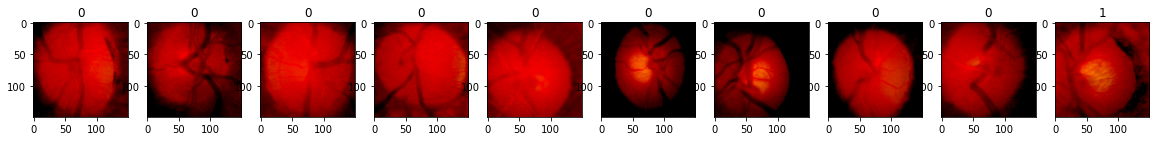

In [131]:
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()

In [132]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [133]:
model = tf.keras.Sequential(name='glaucoma_CNN')

model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

In [134]:
model(images[:1])


<tf.Tensor: id=39278, shape=(1, 2), dtype=float32, numpy=array([[0.5116129 , 0.48838705]], dtype=float32)>

In [135]:
checkpoint_path = "./train/glaucoma_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [136]:


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "glaucoma_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_20 (Conv)               multiple                  2048      
_________________________________________________________________
conv_21 (Conv)               multiple                  37184     
_________________________________________________________________
conv_22 (Conv)               multiple                  37184     
_________________________________________________________________
conv_23 (Conv)               multiple                  74368     
_________________________________________________________________
conv_24 (Conv)               multiple                  148096    
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                 

In [137]:
train_len = len(glob(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/training_set/', 'train', 'normal', '*.png'))) * 2
val_len = len(glob(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/validation/', 'val', 'normal', '*.png'))) * 2
test_len = len(glob(os.path.join('/Users/insafbenlamari/Documents/memoire/RIM-ONE_DL_images 2/test_set/', 'test', 'normal', '*.png'))) * 2

In [138]:
model.fit(train_ds, steps_per_epoch=train_len / 20,
        validation_data=val_ds,
          validation_steps=val_len/20,
          epochs=60,
          callbacks=[cp_callback]
          )


Train for 19.7 steps, validate for 1.8 steps
Epoch 1/60
19/19 [===========================>..] - ETA: 2s - loss: 0.5724 - accuracy: 0.7158
Epoch 00001: val_loss improved from inf to 0.76925, saving model to ./train/glaucoma_cnn/cp-0001.ckpt
20/19 [==============================] - 68s 3s/step - loss: 0.5528 - accuracy: 0.7277 - val_loss: 0.7692 - val_accuracy: 0.4167
Epoch 2/60
19/19 [===========================>..] - ETA: 2s - loss: 0.4279 - accuracy: 0.7882
Epoch 00002: val_loss improved from 0.76925 to 0.76513, saving model to ./train/glaucoma_cnn/cp-0002.ckpt
20/19 [==============================] - 63s 3s/step - loss: 0.4271 - accuracy: 0.7939 - val_loss: 0.7651 - val_accuracy: 0.5000
Epoch 3/60
19/19 [===========================>..] - ETA: 2s - loss: 0.3513 - accuracy: 0.8204
Epoch 00003: val_loss improved from 0.76513 to 0.76178, saving model to ./train/glaucoma_cnn/cp-0003.ckpt
20/19 [==============================] - 73s 4s/step - loss: 0.3483 - accuracy: 0.8270 - val_loss: 0.

Epoch 30/60
19/19 [===========================>..] - ETA: 2s - loss: 0.1048 - accuracy: 0.9678
Epoch 00030: val_loss improved from 0.75696 to 0.73633, saving model to ./train/glaucoma_cnn/cp-0030.ckpt
20/19 [==============================] - 73s 4s/step - loss: 0.1034 - accuracy: 0.9669 - val_loss: 0.7363 - val_accuracy: 0.6389
Epoch 31/60
19/19 [===========================>..] - ETA: 2s - loss: 0.1150 - accuracy: 0.9491
Epoch 00031: val_loss did not improve from 0.73633
20/19 [==============================] - 82s 4s/step - loss: 0.1143 - accuracy: 0.9491 - val_loss: 0.9814 - val_accuracy: 0.4722
Epoch 32/60
19/19 [===========================>..] - ETA: 2s - loss: 0.0885 - accuracy: 0.9625
Epoch 00032: val_loss did not improve from 0.73633
20/19 [==============================] - 78s 4s/step - loss: 0.0860 - accuracy: 0.9637 - val_loss: 1.0779 - val_accuracy: 0.5278
Epoch 33/60
19/19 [===========================>..] - ETA: 2s - loss: 0.0666 - accuracy: 0.9759
Epoch 00033: val_loss did

19/19 [===========================>..] - ETA: 1s - loss: 0.0335 - accuracy: 0.9866
Epoch 00059: val_loss did not improve from 0.65514
20/19 [==============================] - 57s 3s/step - loss: 0.0349 - accuracy: 0.9847 - val_loss: 0.9300 - val_accuracy: 0.7778
Epoch 60/60
19/19 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 1.0000
Epoch 00060: val_loss did not improve from 0.65514
20/19 [==============================] - 58s 3s/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 1.0830 - val_accuracy: 0.6944


In [139]:
model.evaluate(test_ds, steps=test_len / 20)


10/10 [==============================] - 15s 1s/step - loss: 0.5899 - accuracy: 0.7980


[0.5899186685681344, 0.7979798]

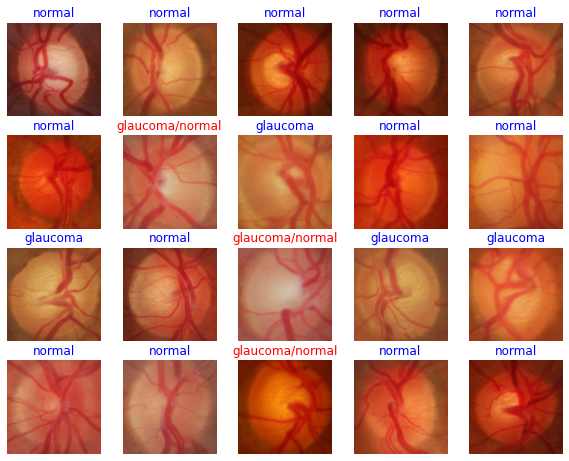

In [140]:
test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'normal', 1: 'glaucoma'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')